Grupo 3: David Davó Laviña, Ela Shepherd Arévalo

In [ ]:
import numpy as np
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
custom_palette = ["#ff2cef", "#1fcc42", "#ffeb00"]
sns.set_palette(custom_palette)
np.random.seed(0x2A)

# Descripción y visualización del conjunto de datos

Este conjunto de datos nos describe diversas propiedades de todos los países del mundo, desde la población, área y PIB hasta porcentajes de alfabetización, tasa de mortalidad y nacimiento, teléfonos por cada 1000 personas, etc...

Con estos datos intentaremos vincular el PIB (GDP en Inglés) a un conjunto de variables para intentar predecirlo mediante una regresión con un MLP. 

In [ ]:
# Cargamos el dataframe con los datos
df = pd.read_csv("https://gitlab.com/daviddavo/IA2/-/raw/master/countries%20of%20the%20world.csv", header=0, sep=",", index_col=0, decimal=",").drop("Region", axis=1).drop("Climate", axis=1).dropna()
df

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service
Country,,,,,,,,,,,,,,,,,
Afghanistan,31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,46.60,20.34,0.380,0.240,0.380
Albania,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,15.11,5.22,0.232,0.188,0.579
Algeria,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,17.14,4.61,0.101,0.600,0.298
Angola,12127071,1246700,9.7,0.13,0.00,191.19,1900.0,42.0,7.8,2.41,0.24,97.35,45.11,24.20,0.096,0.658,0.246
Anguilla,13477,102,132.1,59.80,10.76,21.03,8600.0,95.0,460.0,0.00,0.00,100.00,14.17,5.34,0.040,0.180,0.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,25730435,912050,28.2,0.31,-0.04,22.20,4800.0,93.4,140.1,2.95,0.92,96.13,18.71,4.92,0.040,0.419,0.541
Vietnam,84402966,329560,256.1,1.05,-0.45,25.95,2500.0,90.3,187.7,19.97,5.95,74.08,16.86,6.22,0.209,0.410,0.381
Yemen,21456188,527970,40.6,0.36,0.00,61.50,800.0,50.2,37.2,2.78,0.24,96.98,42.89,8.30,0.135,0.472,0.393


In [ ]:
df.describe().transpose() # La transponemos para que sea más legible

,count,mean,std,min,25%,50%,75%,max
Population,194.0,3.347818e+07,1.269602e+08,13477.000,1.349476e+06,6.881405e+06,2.238307e+07,1.313974e+09
Area (sq. mi.),194.0,6.860004e+05,1.917360e+06,28.000,2.039725e+04,1.195100e+05,5.116955e+05,1.707520e+07
Pop. Density (per sq. mi.),194.0,2.859912e+02,1.327761e+03,1.800,2.675000e+01,6.980000e+01,1.777500e+02,1.618300e+04
Coastline (coast/area ratio),194.0,1.563567e+01,7.123686e+01,0.000,9.250000e-02,5.400000e-01,4.897500e+00,8.706600e+02
Net migration,194.0,-9.376289e-02,4.642243e+00,-20.990,-1.032500e+00,0.000000e+00,6.750000e-01,2.306000e+01
Infant mortality (per 1000 births),194.0,3.867835e+01,3.662244e+01,2.290,8.987500e+00,2.424500e+01,6.257500e+01,1.911900e+02
GDP ($ per capita),194.0,9.451546e+03,1.014251e+04,500.000,1.825000e+03,5.400000e+03,1.370000e+04,5.510000e+04
Literacy (%),194.0,8.216495e+01,1.989587e+01,17.600,7.010000e+01,9.095000e+01,9.797500e+01,1.000000e+02
Phones (per 1000),194.0,2.126397e+02,2.092544e+02,0.200,2.825000e+01,1.403500e+02,3.396000e+02,8.980000e+02
Arable (%),194.0,1.442603e+01,1.340943e+01,0.000,3.805000e+00,1.069000e+01,2.105750e+01,6.211000e+01


In [ ]:
df.dtypes

Population                              int64
Area (sq. mi.)                          int64
Pop. Density (per sq. mi.)            float64
Coastline (coast/area ratio)          float64
Net migration                         float64
Infant mortality (per 1000 births)    float64
GDP ($ per capita)                    float64
Literacy (%)                          float64
Phones (per 1000)                     float64
Arable (%)                            float64
Crops (%)                             float64
Other (%)                             float64
Birthrate                             float64
Deathrate                             float64
Agriculture                           float64
Industry                              float64
Service                               float64
dtype: object

Generamos el pairplot, mostrando la regresión lineal entre las distintas variables y a continuación mostramos una matriz con los coeficientes de correlación para intentar elegir las mejores.

![](https://i.kym-cdn.com/entries/icons/original/000/032/744/maneuver.jpg)

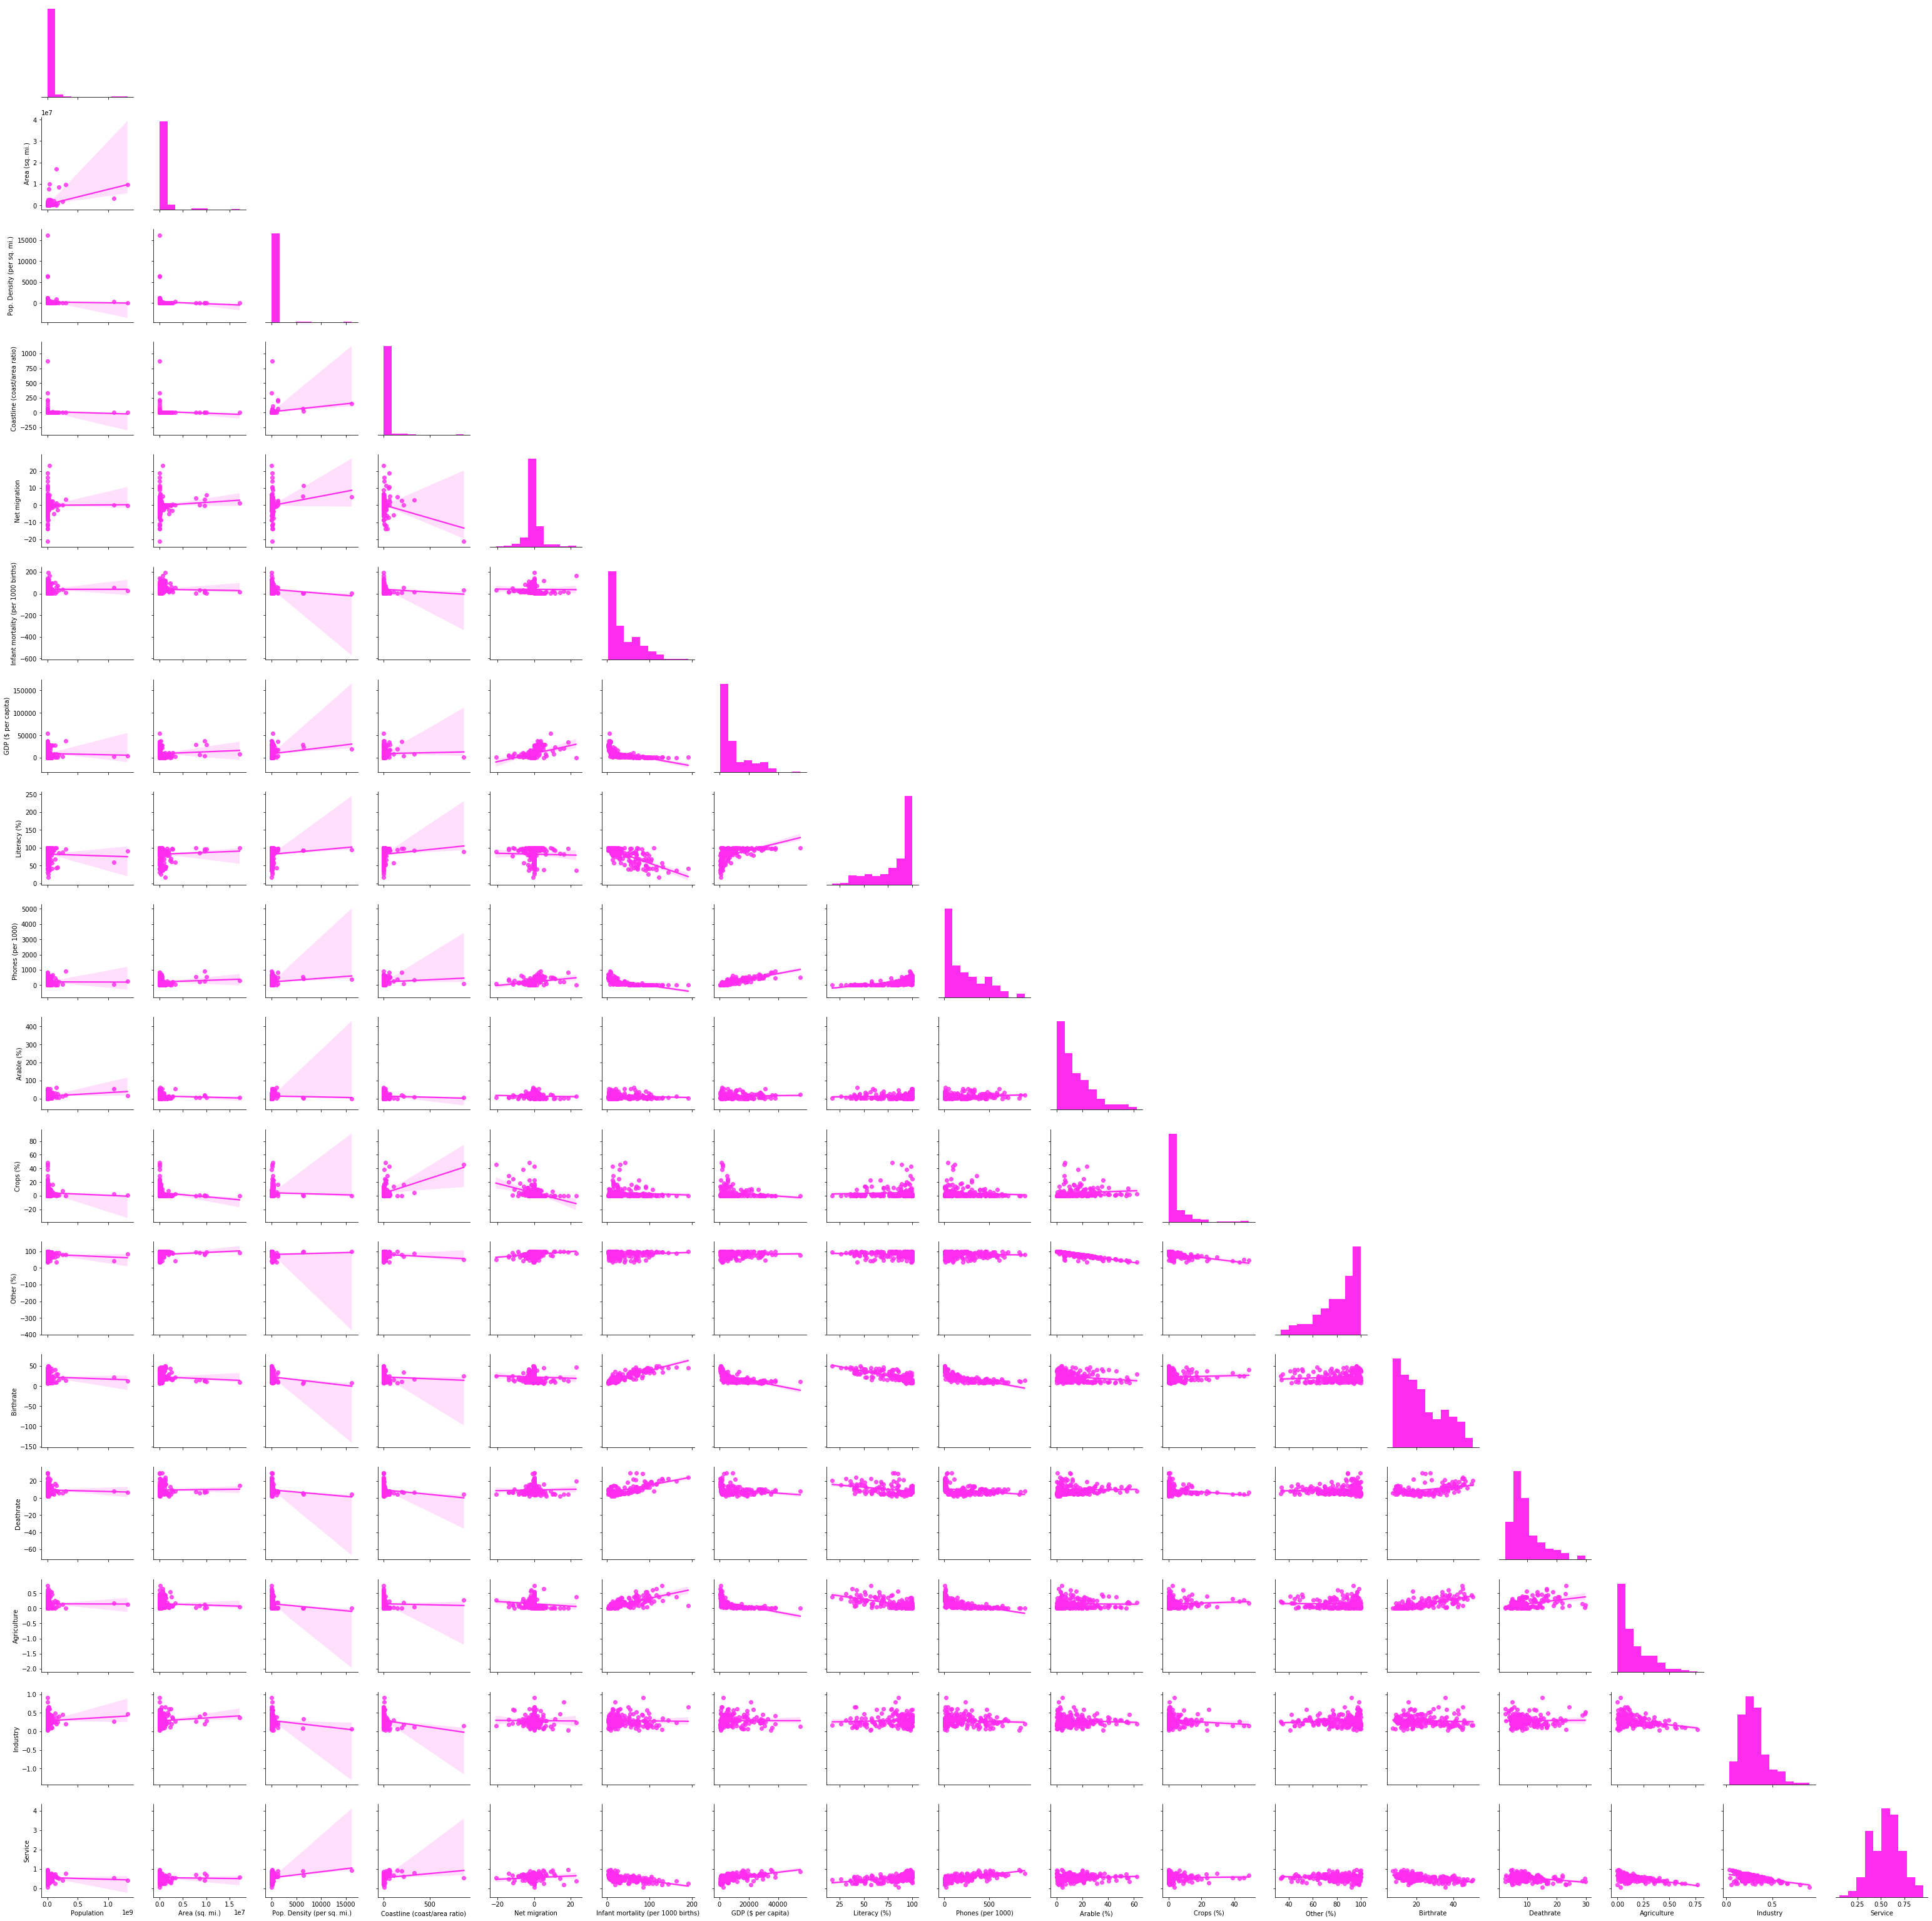

In [ ]:
sns.pairplot(df, corner=True, kind="reg")

In [ ]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
corr.round(2).style.background_gradient(cmap='coolwarm')

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service
Population,1,0.47,-0.02,-0.05,0.01,0,-0.04,-0.04,-0.01,0.18,-0.06,-0.12,-0.06,-0.05,-0.01,0.09,-0.07
Area (sq. mi.),0.47,1,-0.06,-0.08,0.08,-0.04,0.08,0.05,0.1,-0.09,-0.15,0.15,-0.09,0.02,-0.06,0.11,-0.04
Pop. Density (per sq. mi.),-0.02,-0.06,1,0.17,0.16,-0.14,0.17,0.08,0.16,-0.05,-0.03,0.06,-0.17,-0.13,-0.14,-0.15,0.25
Coastline (coast/area ratio),-0.05,-0.08,0.17,1,-0.24,-0.1,0.03,0.1,0.1,-0.07,0.4,-0.13,-0.06,-0.15,-0.03,-0.19,0.19
Net migration,0.01,0.08,0.16,-0.24,1,-0.01,0.41,-0.03,0.26,-0.05,-0.4,0.24,-0.06,0.04,-0.12,-0.01,0.12
Infant mortality (per 1000 births),0,-0.04,-0.14,-0.1,-0.01,1,-0.62,-0.76,-0.7,-0.15,-0.1,0.17,0.86,0.67,0.73,-0.03,-0.63
GDP ($ per capita),-0.04,0.08,0.17,0.03,0.41,-0.62,1,0.52,0.86,0.06,-0.2,0.05,-0.64,-0.24,-0.61,-0,0.55
Literacy (%),-0.04,0.05,0.08,0.1,-0.03,-0.76,0.52,1,0.61,0.11,0.07,-0.12,-0.79,-0.39,-0.62,0.07,0.5
Phones (per 1000),-0.01,0.1,0.16,0.1,0.26,-0.7,0.86,0.61,1,0.13,-0.12,-0.05,-0.74,-0.31,-0.64,-0.1,0.67
Arable (%),0.18,-0.09,-0.05,-0.07,-0.05,-0.15,0.06,0.11,0.13,1,0.11,-0.88,-0.23,0.04,-0.02,-0.1,0.11


Podemos observar una correlación muy alta entre la mortalidad infantil, la tasa de natalidad, la tasa de mortalidad y que su GDP se base en la agircultura. Estos valores también son inversamente proporcionales a la tasa de alfabetización, al GDP y al número de teléfonos por cada 1000 habitantes. 

El fenómeno de la transición demográfica establece que cuando aumenta el desarrollo de un país (GDP, industrialización, servicios, alfabetización, etc.) disminuyen tanto la tasa de natalidad como la de mortalidad, aumentando a su paso la población total, por lo que se conoce que dicha relación es causal.

También podemos observar que hay una alta correlación entre el GDP de un país y el número de teléfonos por cada 1000 habitantes.

# Preparación de datos

Como lo que queremos hacer es predecir el GDP en cuanto a otras variables, cogeremos las 5 con mayor correlación.

In [ ]:
fdf = df[corr["GDP ($ per capita)"].abs().nlargest(6).keys()]
fdf

,GDP ($ per capita),Phones (per 1000),Birthrate,Infant mortality (per 1000 births),Agriculture,Service
Country,,,,,,
Afghanistan,700.0,3.2,46.60,163.07,0.380,0.380
Albania,4500.0,71.2,15.11,21.52,0.232,0.579
Algeria,6000.0,78.1,17.14,31.00,0.101,0.298
Angola,1900.0,7.8,45.11,191.19,0.096,0.246
Anguilla,8600.0,460.0,14.17,21.03,0.040,0.780
...,...,...,...,...,...,...
Venezuela,4800.0,140.1,18.71,22.20,0.040,0.541
Vietnam,2500.0,187.7,16.86,25.95,0.209,0.381
Yemen,800.0,37.2,42.89,61.50,0.135,0.393


Debido a que los pesos se inicializan de forma aleatoria, el no escalar las variables de entrada puede dar errores muy grandes en variables no muy importantes y errores muy pequeños en variables importantes, por lo que escalaremos las variables.

In [ ]:
scaler = StandardScaler()
fdft = pd.DataFrame(data=scaler.fit_transform(fdf), columns=fdf.columns, index=fdf.index)
fdft

,GDP ($ per capita),Phones (per 1000),Birthrate,Infant mortality (per 1000 births),Agriculture,Service
Country,,,,,,
Afghanistan,-0.865090,-1.003475,2.109065,3.405385,1.510019,-1.067456
Albania,-0.489460,-0.677671,-0.670214,-0.469732,0.520390,0.142580
Algeria,-0.341185,-0.644612,-0.491048,-0.210205,-0.355566,-1.566064
Angola,-0.746470,-0.981435,1.977559,4.175207,-0.389000,-1.882254
Anguilla,-0.084175,1.185162,-0.753178,-0.483147,-0.763454,1.364778
...,...,...,...,...,...,...
Venezuela,-0.459805,-0.347555,-0.352481,-0.451117,-0.763454,-0.088482
Vietnam,-0.687160,-0.119492,-0.515761,-0.348455,0.366596,-1.061375
Yemen,-0.855205,-0.840573,1.781624,0.624773,-0.128219,-0.988408


# Validación cruzada

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

cv1_scores_mean = []
cv1_scores_std = []
cv2_scores_mean = []
cv2_scores_std = []

MAX_ITER = 800
N_FOLDS = 5
X = fdft.drop(columns="GDP ($ per capita)") # No tiene sentido predecir usando la variable a predecir
Y = fdft["GDP ($ per capita)"]

alpha_range = 10.0 ** -np.arange(1, 20)
for alpha in alpha_range:
    mlp = MLPRegressor(hidden_layer_sizes=(200,), activation="relu", alpha=alpha, max_iter=MAX_ITER)
    scores = cross_val_score(mlp, X, Y, cv=N_FOLDS, scoring="neg_mean_squared_error")
    cv1_scores_mean.append(scores.mean())
    cv1_scores_std.append(scores.std())

    mlp = MLPRegressor(hidden_layer_sizes=(50,50), activation="relu", alpha=alpha, max_iter=MAX_ITER)
    scores = cross_val_score(mlp, X, Y, cv=N_FOLDS, scoring="neg_mean_squared_error")
    cv2_scores_mean.append(scores.mean())
    cv2_scores_std.append(scores.std())

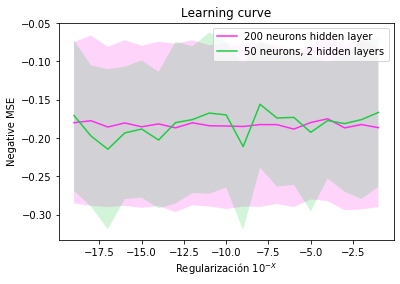

In [ ]:
plt.plot(np.log10(alpha_range), cv1_scores_mean, label="200 neurons hidden layer")
plt.fill_between(np.log10(alpha_range), np.array(cv1_scores_mean) + np.array(cv1_scores_std), np.array(cv1_scores_mean) - np.array(cv1_scores_std), alpha=.2)
plt.plot(np.log10(alpha_range), cv2_scores_mean, label="50 neurons, 2 hidden layers")
plt.fill_between(np.log10(alpha_range), np.array(cv2_scores_mean) + np.array(cv2_scores_std), np.array(cv2_scores_mean) - np.array(cv2_scores_std), alpha=.2)

plt.title("Learning curve")
plt.xlabel("Regularización $10^{-X}$")
plt.ylabel("Negative MSE")
plt.legend(loc="best")
plt.show()

La media del MSE parece ser ligeramente mayor en el segundo MLP, con dos capas de 50 neuronas cada una, y con menor desviación típica. Sobre el $\alpha$ a elegir, parece maximizarse ligeramente en  $10^{-8}$, antes de volver a decaer


# Valoración del error

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(50,50), activation="relu", alpha=10**-8, max_iter=MAX_ITER)
mlp = mlp.fit(X, Y)
predicts_scaled = mlp.predict(X)
X_copy = X.copy()
X_copy.insert(0, "GDP predicted ($ per capita)", predicts_scaled)
dfp = pd.DataFrame(scaler.inverse_transform(X_copy), index=fdft.index, columns=X_copy.columns)
dfp.insert(1, "GDP observed ($ per capita)", fdf["GDP ($ per capita)"])
dfp.insert(2, "GDP diff ($ per capita)", dfp["GDP predicted ($ per capita)"] - dfp["GDP observed ($ per capita)"])
dfp

,GDP predicted ($ per capita),GDP observed ($ per capita),GDP diff ($ per capita),Phones (per 1000),Birthrate,Infant mortality (per 1000 births),Agriculture,Service
Country,,,,,,,,
Afghanistan,550.670080,700.0,-149.329920,3.2,46.60,163.07,0.380,0.380
Albania,3190.715744,4500.0,-1309.284256,71.2,15.11,21.52,0.232,0.579
Algeria,5885.186832,6000.0,-114.813168,78.1,17.14,31.00,0.101,0.298
Angola,1621.656997,1900.0,-278.343003,7.8,45.11,191.19,0.096,0.246
Anguilla,11518.585233,8600.0,2918.585233,460.0,14.17,21.03,0.040,0.780
...,...,...,...,...,...,...,...,...
Venezuela,7003.860486,4800.0,2203.860486,140.1,18.71,22.20,0.040,0.541
Vietnam,3819.956195,2500.0,1319.956195,187.7,16.86,25.95,0.209,0.381
Yemen,758.909557,800.0,-41.090443,37.2,42.89,61.50,0.135,0.393


r = 0.963557
Predicted: avg = 9427.494678, std = 9605.177141
Observed:  avg = 9451.546392, std = 10142.514158


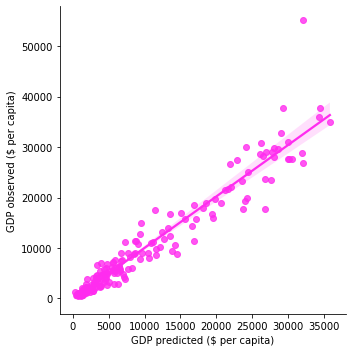

In [ ]:
print("r = %f" % (dfp["GDP predicted ($ per capita)"].corr(dfp["GDP observed ($ per capita)"])))
print("Predicted: avg = %f, std = %f" % (dfp["GDP predicted ($ per capita)"].mean(), dfp["GDP predicted ($ per capita)"].std()))
print("Observed:  avg = %f, std = %f" % (dfp["GDP observed ($ per capita)"].mean(), dfp["GDP observed ($ per capita)"].std()))
sns.lmplot("GDP predicted ($ per capita)", "GDP observed ($ per capita)", dfp)

Observamos una alta correlación (r = 0.97) entre el GDP que se ha predicho con el GDP observado, con algunos "outliers". Para tratar de identificar dichos outliers, vamos a separar el dataframe en 3 clases, dependiendo si se ha sobreestimado, subestimado, o estimado bien el GDP, y dibujar el pairplot.
Se considerará sobreestimado/subestimado si se sale del doble de la desviación típica

In [ ]:
def f(row):
    over_boundary = dfp["GDP diff ($ per capita)"].mean() + 2*dfp["GDP diff ($ per capita)"].std()
    under_boundary = dfp["GDP diff ($ per capita)"].mean() - 2*dfp["GDP diff ($ per capita)"].std()

    if row["GDP diff ($ per capita)"] > over_boundary:
        return "over"
    if row["GDP diff ($ per capita)"] < under_boundary:
        return "under"
    return "well"

cdfp = dfp.copy()
cdfp["stimated"] = cdfp.apply(f, axis="columns")
# Incluimos las variables que quitamos anteriormente
cdfp = cdfp.merge(df[df.columns.difference(cdfp.columns)], left_index=True, right_index=True, how="outer").drop("GDP ($ per capita)", axis="columns")
cdfp

,GDP predicted ($ per capita),GDP observed ($ per capita),GDP diff ($ per capita),Phones (per 1000),Birthrate,Infant mortality (per 1000 births),Agriculture,Service,stimated,Arable (%),Area (sq. mi.),Coastline (coast/area ratio),Crops (%),Deathrate,Industry,Literacy (%),Net migration,Other (%),Pop. Density (per sq. mi.),Population
Country,,,,,,,,,,,,,,,,,,,,
Afghanistan,550.670080,700.0,-149.329920,3.2,46.60,163.07,0.380,0.380,well,12.13,647500,0.00,0.22,20.34,0.240,36.0,23.06,87.65,48.0,31056997
Albania,3190.715744,4500.0,-1309.284256,71.2,15.11,21.52,0.232,0.579,well,21.09,28748,1.26,4.42,5.22,0.188,86.5,-4.93,74.49,124.6,3581655
Algeria,5885.186832,6000.0,-114.813168,78.1,17.14,31.00,0.101,0.298,well,3.22,2381740,0.04,0.25,4.61,0.600,70.0,-0.39,96.53,13.8,32930091
Angola,1621.656997,1900.0,-278.343003,7.8,45.11,191.19,0.096,0.246,well,2.41,1246700,0.13,0.24,24.20,0.658,42.0,0.00,97.35,9.7,12127071
Anguilla,11518.585233,8600.0,2918.585233,460.0,14.17,21.03,0.040,0.780,well,0.00,102,59.80,0.00,5.34,0.180,95.0,10.76,100.00,132.1,13477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,7003.860486,4800.0,2203.860486,140.1,18.71,22.20,0.040,0.541,well,2.95,912050,0.31,0.92,4.92,0.419,93.4,-0.04,96.13,28.2,25730435
Vietnam,3819.956195,2500.0,1319.956195,187.7,16.86,25.95,0.209,0.381,well,19.97,329560,1.05,5.95,6.22,0.410,90.3,-0.45,74.08,256.1,84402966
Yemen,758.909557,800.0,-41.090443,37.2,42.89,61.50,0.135,0.393,well,2.78,527970,0.36,0.24,8.30,0.472,50.2,0.00,96.98,40.6,21456188


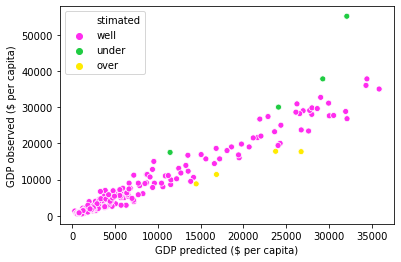

In [ ]:
sns.scatterplot("GDP predicted ($ per capita)", "GDP observed ($ per capita)", data=cdfp, hue="stimated")

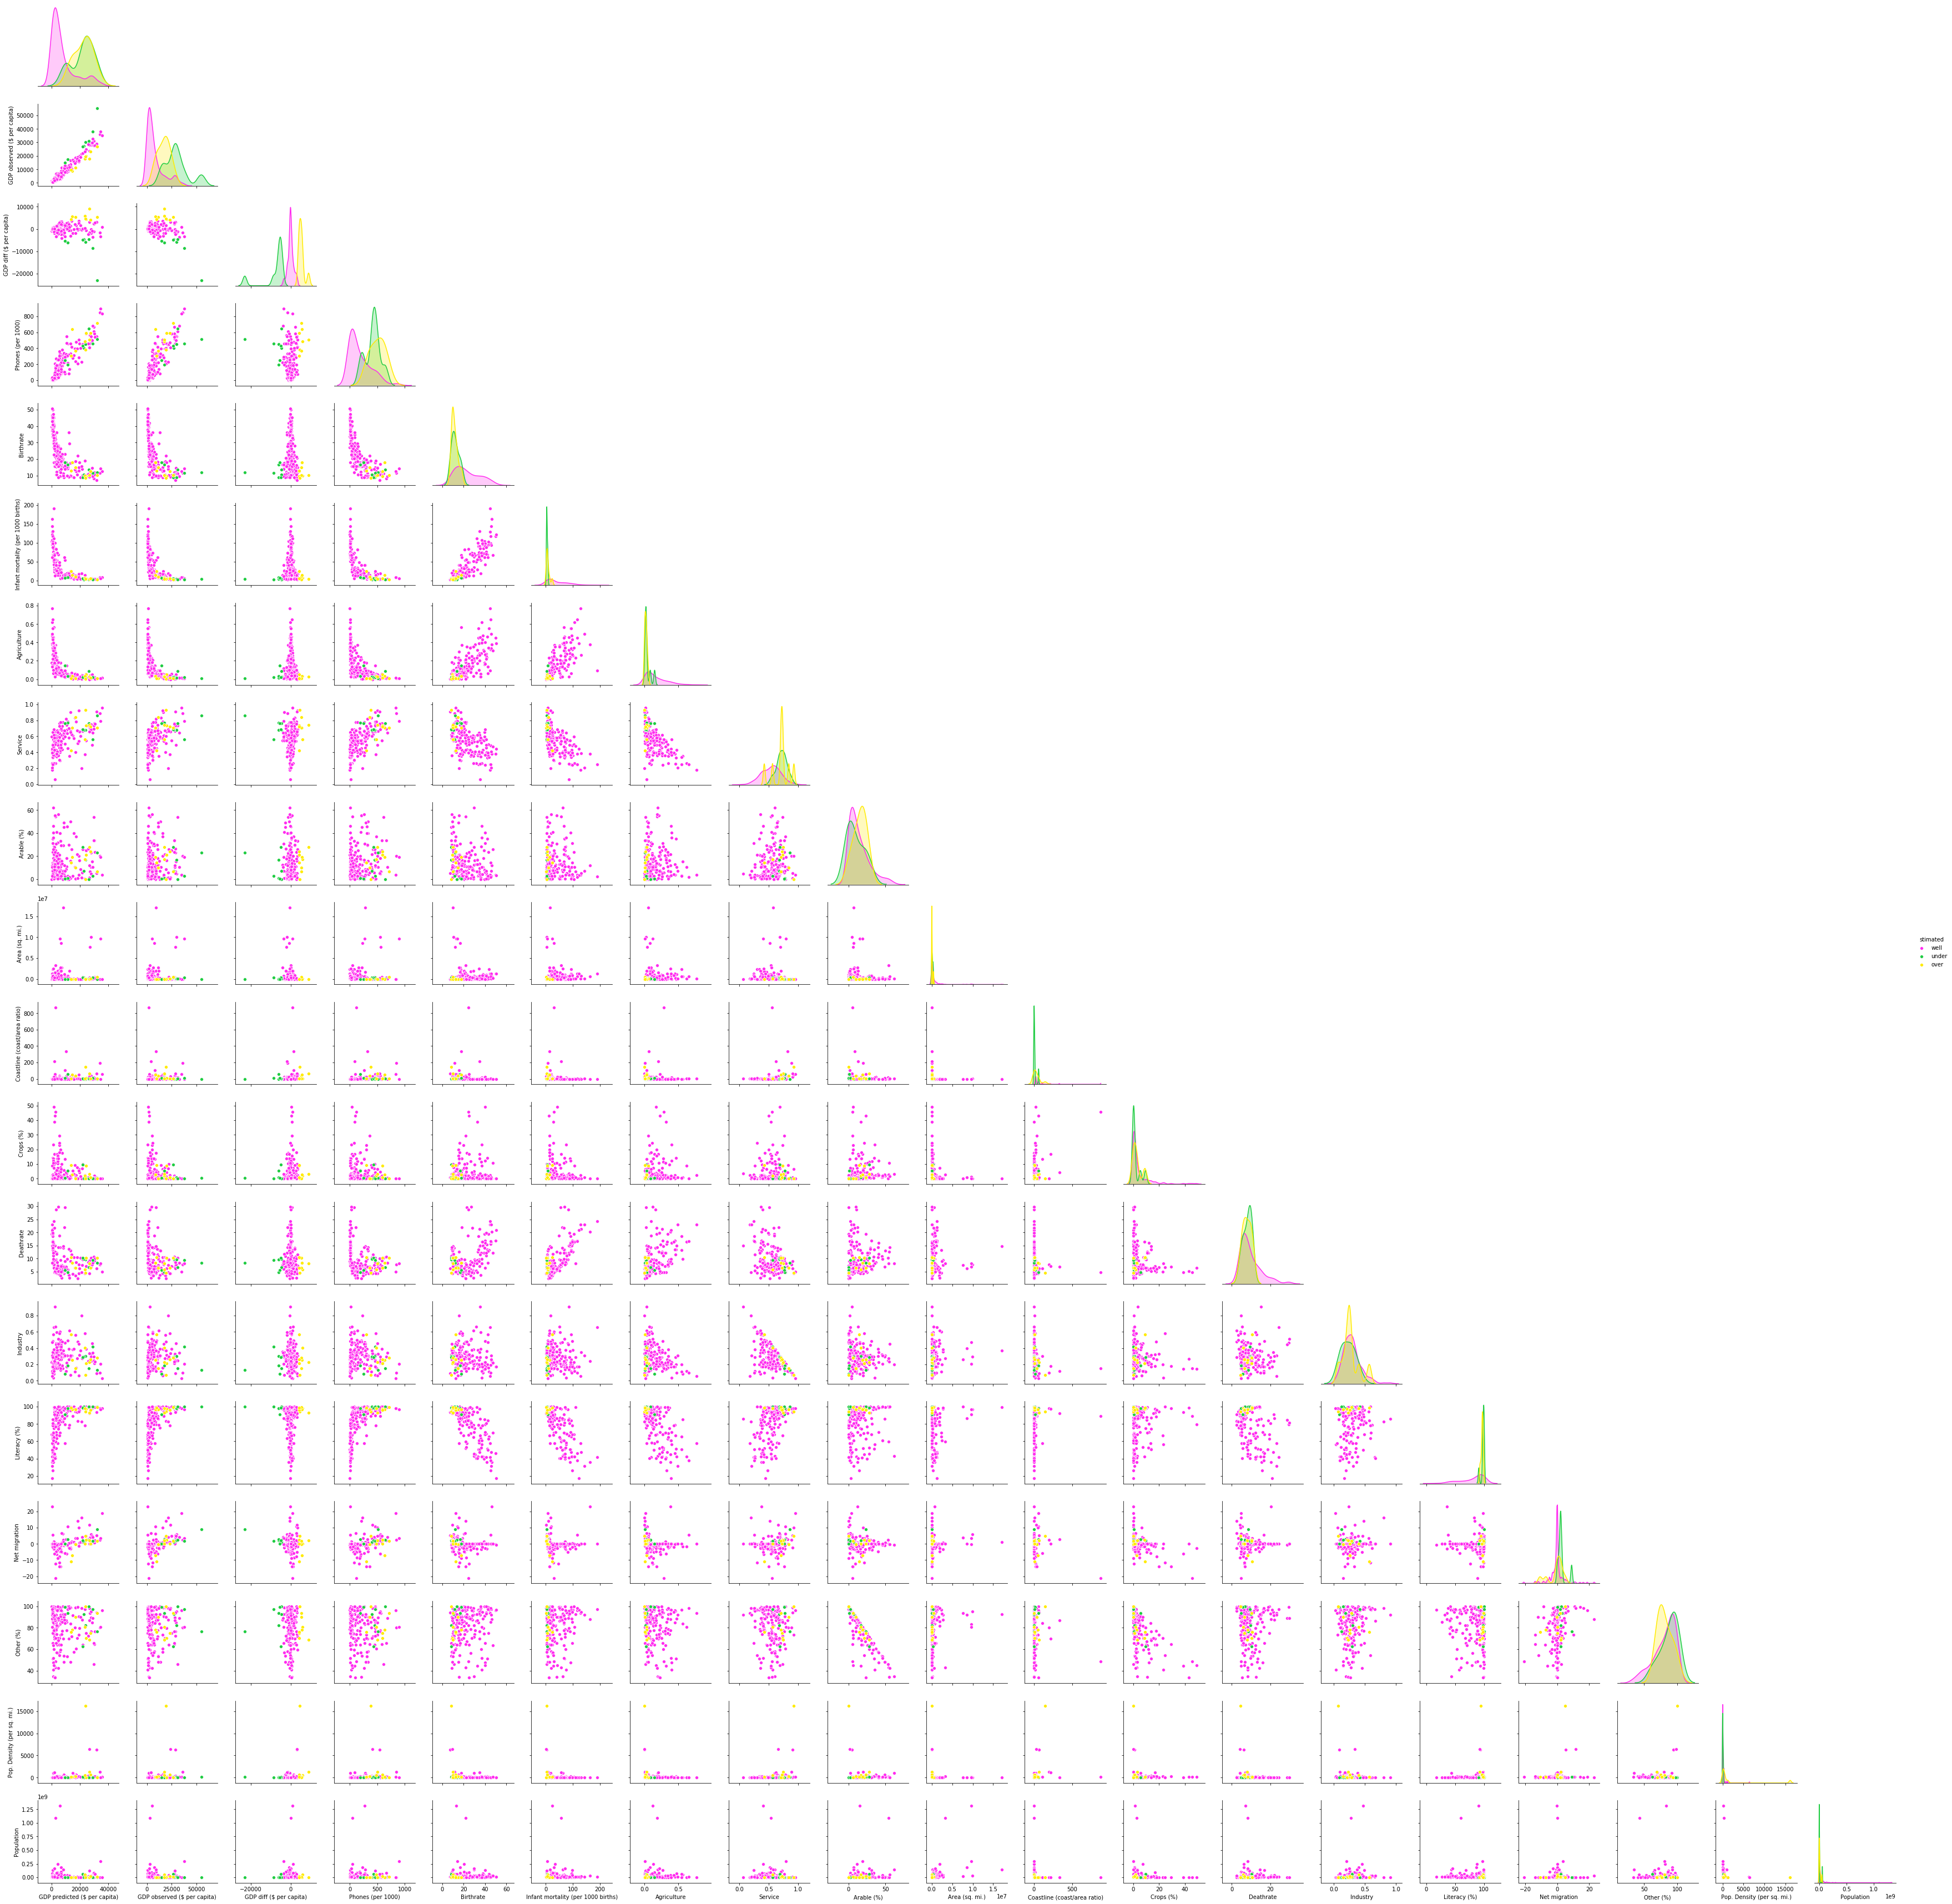

In [ ]:
sns.pairplot(cdfp, hue="stimated", corner=True)

A continuación, visualizaremos una lista de dichos outliers y sus variables

In [ ]:
cdfp.query('stimated != "well"').sort_values("GDP diff ($ per capita)")

,GDP predicted ($ per capita),GDP observed ($ per capita),GDP diff ($ per capita),Phones (per 1000),Birthrate,Infant mortality (per 1000 births),Agriculture,Service,stimated,Arable (%),Area (sq. mi.),Coastline (coast/area ratio),Crops (%),Deathrate,Industry,Literacy (%),Net migration,Other (%),Pop. Density (per sq. mi.),Population
Country,,,,,,,,,,,,,,,,,,,,
Luxembourg,32077.848614,55100.0,-23022.151386,515.4,11.94,4.81,0.010,0.860,under,23.28,2586,0.00,0.40,8.41,0.130,100.0,8.97,76.32,183.5,474413
Norway,29272.026870,37800.0,-8527.973130,461.7,11.46,3.70,0.021,0.564,under,2.87,323802,7.77,0.00,9.40,0.415,100.0,1.74,97.13,14.2,4610820
French Polynesia,11447.684121,17500.0,-6052.315879,194.5,16.68,8.44,0.031,0.769,under,0.82,4167,60.60,5.46,4.69,0.190,98.0,2.94,93.72,65.9,274578
Austria,24105.232705,30000.0,-5894.767295,452.2,8.74,4.66,0.018,0.678,under,16.91,83870,0.00,0.86,9.76,0.304,98.0,2.00,82.23,97.7,8192880
Netherlands Antilles,16861.740593,11400.0,5461.740593,365.3,14.78,10.03,0.010,0.840,over,10.00,960,37.92,0.00,6.45,0.150,96.7,-0.41,90.00,231.0,221736
Saint Kitts & Nevis,14496.629270,8800.0,5696.629270,638.9,18.02,14.49,0.035,0.707,over,19.44,261,51.72,2.78,8.33,0.258,97.0,-7.11,77.78,149.9,39129
"Korea, South",23768.266520,17800.0,5968.266520,486.1,10.00,7.05,0.033,0.563,over,17.18,98480,2.45,1.95,5.85,0.403,97.9,0.00,80.87,496.0,48846823
Malta,26744.465537,17700.0,9044.465537,505.0,10.22,3.89,0.030,0.740,over,28.13,316,62.28,3.13,8.10,0.230,92.8,2.07,68.74,1266.5,400214


Podemos ver que todos los países de la lista tienen valores en las variables elegidas para la regresión ligeramente cercanas a las medias de esas variables, por lo que nuestro modelo puede equivocarse en países aparentemente "normales".

- A **Luxemburgo** se le ha asignado un GDP alto, por encima del tercer cuartil, la diferencia con su GDP real es muy grande (-23.000 $), ya que Luxemburgo es muy atractivo para que empresas extranjeras tengan allí sus sedes, aumentando considerablemente el GDP. Se podría solucionar con información de las empresas que se instalan en dicho país.

- Con **Noruega** tenemos el mismo problema, se le ha asignado un GDP alto, por encima del tercer cuartil, pero nos seguimos quedando cortos. Esto puede ser debido a que es el mayor productor de petróleo y gas natural del mundo fuera de oriente medio, lo que suma bastante al GDP. Tal vez nuestro modelo mejoraría con información de los recursos naturales de los que dispone el país, el tipo de industria a la que se dedica, o sus exportaciones.

- El principal producto de exportación de la **Polinesia Francesa** es la perla negra Tahitiana (55% del valor de sus exportaciones). También exporta grandes cantidades de cobalto. Tenemos el mismo problema y solución que con Noruega.

- **Austria** tiene una economía de mercado muy desarrollada, no reflejada en nuestras variables. El problema es el mismo que con Luxemburgo.

---
Sobre las sobrestimaciones, podemos ver que se dedican muy poco a la agricultura, lo que suele indicar un alto GDP, pero tal vez no tan alto.

- **Malta** tiene muy desarrollado el sector servicios, pues su economía depende en gran medida del turismo, pero el turismo no genera tanto dinero como parece. Se puede solucionar con un indicador del turismo de un país.

- El mismo problema ocurre con **San Cristóbal y Nieves** y las **Antillas Neerlandesas**, altamente dependientes del turismo.

- **Korea el Sur** también tiene parte de su economía dedicada al turismo. Aunque la diferencia absoluta sea mucha, la diferencia relativa no es tan grande.

